In [103]:
import os
import time
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as data
from sklearn.preprocessing import OneHotEncoder

In [104]:
dataPath = os.path.join('.', 'quant4533')
outputPath = os.path.join('.', 'predict.csv')

train_path = os.path.join(dataPath, 'merged.csv')
pre_path = os.path.join(dataPath, 'pre_data.csv')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [105]:
origin_train = os.path.join(dataPath, 'ruc_Class25Q1_train.csv')
origin_test = os.path.join(dataPath, 'ruc_Class25Q1_test.csv')
origin_detail = os.path.join(dataPath, 'ruc_Class25Q1_test.csv')

In [106]:
#! 数据处理预处理部分基本是用sql完成
#! 如果需要可以进一步提供sql代码


In [107]:
def get_data(train_path):
    test_data = pd.read_csv(train_path)
    labels = test_data.iloc[:, 0]
    features = test_data.iloc[:, 1:]

    labels = np.log1p(labels)
    plt.hist(labels, bins=100)
    plt.show()

    # 确定数值型和非数值型（分类）列
    numerical_cols = features.select_dtypes(
        include=['number']).columns.drop(['朝南', '朝西', '朝东', '朝北', '地铁', '公交', '商超', '医院', '公园'])
    categorical_cols = test_data.select_dtypes(exclude=['number']).columns

    # 计算数值型列的二次项
    quadratic_features = features[numerical_cols] ** 2
    quadratic_features.columns = [col + '_平方' for col in numerical_cols]

    numerical_features = features[numerical_cols]
    numerical_features = pd.concat([numerical_features, quadratic_features], axis=1)
    new_numerical_cols = numerical_cols.union(quadratic_features.columns)

    numerical_features[new_numerical_cols] = numerical_features[new_numerical_cols].apply(
        lambda x: (x - x.mean()) / (x.std()))

    numerical_features[new_numerical_cols] = numerical_features[new_numerical_cols].fillna(0)

    encoder = OneHotEncoder(handle_unknown='ignore')
    encoder.fit(features[categorical_cols])
    categorical_encoded = encoder.transform(features[categorical_cols])
    encoded_columns = encoder.get_feature_names_out(categorical_cols)
    categorical_encoded = pd.DataFrame(categorical_encoded.toarray(), columns=encoded_columns)

    features = pd.concat([numerical_features, categorical_encoded], axis=1)

    bool_columns = features.select_dtypes(include=['bool']).columns
    features[bool_columns] = features[bool_columns].astype(int)

    # 将 features 和 labels 转换为张量
    features_tensor = torch.tensor(
        features.values, dtype=torch.float64).to(device)
    labels_tensor = torch.tensor(labels.values, dtype=torch.float64).to(device)

    num_examples = len(features_tensor)
    index = list(range(num_examples))
    random.shuffle(index)

    # 划分训练集和验证集的索引
    train_size = int(num_examples * 0.8)
    train_index = index[:train_size]
    val_index = index[train_size:]

    train_features = features_tensor[train_index]
    train_labels = labels_tensor[train_index]
    test_features = features_tensor[val_index]
    test_labels = labels_tensor[val_index]

    return train_features, train_labels, test_features, test_labels, encoder, features.columns

In [108]:
def get_predict_data(pre_path, encoder, train_columns):
    test_data = pd.read_csv(pre_path)
    ids = test_data.iloc[:, 0]
    features = test_data.iloc[:, 1:]

    # 确定数值型和非数值型（分类）列
    numerical_cols = features.select_dtypes(
        include=['number']).columns.drop(['朝南', '朝西', '朝东', '朝北'])
    categorical_cols = test_data.select_dtypes(exclude=['number']).columns

    # 计算数值型列的二次项
    quadratic_features = features[numerical_cols] ** 2
    quadratic_features.columns = [col + '_平方' for col in numerical_cols]

    numerical_features = features[numerical_cols]
    numerical_features = pd.concat([numerical_features, quadratic_features], axis=1)
    new_numerical_cols = numerical_cols.union(quadratic_features.columns)

    numerical_features[new_numerical_cols] = numerical_features[new_numerical_cols].apply(
        lambda x: (x - x.mean()) / (x.std()))

    numerical_features[new_numerical_cols] = numerical_features[new_numerical_cols].fillna(0)

    # 对预测集进行转换
    categorical_encoded = encoder.transform(features[categorical_cols])
    encoded_columns = encoder.get_feature_names_out(categorical_cols)
    categorical_encoded = pd.DataFrame(categorical_encoded.toarray(), columns=encoded_columns)

    features = pd.concat([numerical_features, categorical_encoded], axis=1)

    bool_columns = features.select_dtypes(include=['bool']).columns
    features[bool_columns] = features[bool_columns].astype(int)

    # 调整预测数据的列顺序和删除多余列
    for col in train_columns:
        if col not in features.columns:
            features[col] = 0
    features = features[train_columns]

    # 将 features 和 labels 转换为张量
    features_tensor = torch.tensor(
        features.values, dtype=torch.float64).to(device)
    ids_tensor = torch.tensor(ids.values, dtype=torch.float64).to(device)

    return features_tensor, ids_tensor


In [109]:
def data_iter_set(data_array, batch_size, is_shuffle=True):
    dataset = data.TensorDataset(*data_array)
    return data.DataLoader(dataset, batch_size, shuffle=is_shuffle)

In [110]:
def norm_confirm(weight_grad, bias_grad, tolerance):
    count = 0
    tensor2 = torch.zeros_like(weight_grad).to(device)
    tensor2[0, 0] = bias_grad[0]
    cat = torch.cat([weight_grad, tensor2], dim=1)
    params_norm = torch.norm(cat)
    if params_norm < tolerance:
        count += 1
        return count, params_norm
    else:
        count = 0
        return count, params_norm

In [111]:
def loss(y_hat, y):
    l = nn.MSELoss()
    return l(y_hat, y)

In [112]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf')).to(device)
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [113]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [114]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, l_rate, w_decay, batch_size, model , alpha):
    train_ls, test_ls = [], []
    data_iter = data_iter_set((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    if model == 'OLS' or 'LASSO':
        trainer = torch.optim.Adam(net.parameters(), lr=l_rate)
    elif model == 'RIDGE':
        trainer = torch.optim.Adam(
        net.parameters(), lr=l_rate, weight_decay=w_decay)
    else:
        raise ValueError("Invalid model. Choose from OLS/LASSO/RIDGE")

    print('epoch     time(sec)         loss       params_norm')
    for epoch in range(num_epochs):
        start_time = time.time()
        loss_list = []
        for X, y in data_iter:
            trainer.zero_grad()
            y = y.reshape(-1, 1)
            if model == 'OLS' or 'RIDGE':
                l = loss(net(X), y)
            elif model == 'LASSO':
                l = loss(net(X), y) + alpha * \
                    torch.sum(torch.abs(net[0].weight))
            else:
                raise ValueError("Invalid model. Choose from OLS/LASSO/RIDGE")
            l.backward()
            trainer.step()
            # loss_list.append(log_rmse(net, X, y))
            loss_list.append(l.detach())

        with torch.no_grad():
            count, params_norm = norm_confirm(net[0].weight.grad, net[0].bias.grad, 0.1)
        if count == 10:
            break

        end_time = time.time()
        duration = end_time - start_time
        loss_dura = np.mean(loss_list)
        train_ls.append(loss_dura)
        if test_labels is not None:
            # test_ls.append(log_rmse(net, test_features, test_labels.reshape(-1, 1)))
            test_ls.append(loss(net(test_features), test_labels.reshape(-1, 1)).item())
        print(f'{epoch + 1:3d}    {duration:10.2f}    {loss_dura:10.2f}    {params_norm:10.2f}')

    return train_ls, test_ls

In [115]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size, model, alpha):
    train_l_sum, valid_l_sum = 0, 0
    k_result = []
    k_rmse = []
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = nn.Sequential(nn.Linear(X_train.shape[1], 1)).to(device)
        net = net.to(torch.float64)
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size, model, alpha)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        k_result.append(train_ls[-1])
        k_rmse.append(valid_ls[-1])
        plt.plot(list(range(1, num_epochs + 1)), train_ls)
        plt.plot(list(range(1, num_epochs + 1)), valid_ls)
        plt.xlabel(f'epoch{i + 1}')
        plt.ylabel('rmse')
        plt.legend()
        plt.yscale('log')
        plt.show()
    for i in range(k):
        print(f'折{i + 1}，训练log rmse{float(k_result[i]):f}, '
              f'验证log rmse{float(k_rmse[i]):f}')
    return train_l_sum / k, valid_l_sum / k

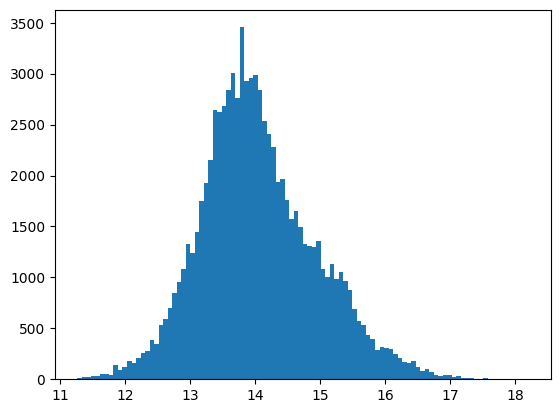

epoch     time(sec)         loss       params_norm
  1          0.63       2629.80         99.97
  2          0.69       1592.52        141.32
  3          0.75       1116.87         51.56
  4          1.11        833.76         58.93
  5          0.84        648.97         42.38
  6          0.75        523.46         25.76
  7          0.82        431.99         22.44
  8          0.67        362.81         16.75
  9          0.80        307.82         59.62
 10          0.74        263.43        387.58
 11          1.21        227.03         10.90
 12          1.07        197.67         53.14
 13          1.24        172.59          9.22
 14          1.08        151.80         52.68
 15          1.03        133.58          9.12
 16          0.87        117.93         12.28
 17          0.64        104.59          5.85
 18          0.70         93.47        100.44
 19          0.71         83.78          5.65
 20          0.71         75.55         12.77
 21          0.68         68.

/tmp/ipykernel_57307/3929267453.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


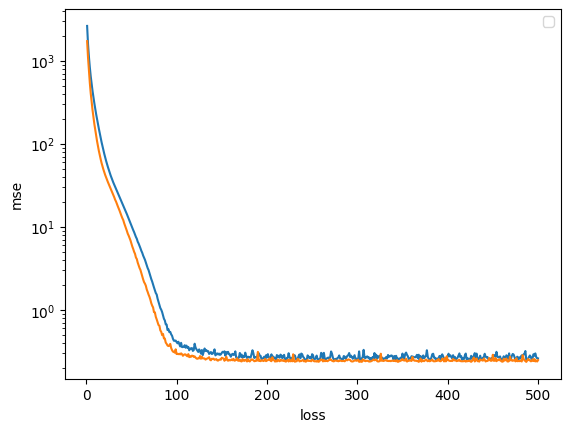

In [116]:
# 超参数设定区
train_features, train_labels, test_features, test_labels, encoder, train_colums = get_data(train_path)
model = 'RIDGE'    # 'OLS' or 'LASSO' or 'RIDGE'
batch_size = 256
num_epochs = 500
l_rate = 0.01
k = 6

alpha = 0.01    # LASSO的参数
w_decay = 0.0005    # RIDGE的参数

net = nn.Sequential(nn.Linear(train_features.shape[1], 1)).to(device)
net = net.to(torch.float64)
net[0].weight.data.normal_(0, 1)
net[0].bias.data.fill_(0)

train_ls, valid_ls = train(net, train_features, train_labels, test_features, test_labels, num_epochs, l_rate, w_decay, batch_size, model, alpha)

plt.plot(list(range(1, num_epochs + 1)), train_ls)
plt.plot(list(range(1, num_epochs + 1)), valid_ls)
plt.xlabel(f'loss')
plt.ylabel('mse')
plt.legend()
plt.yscale('log')
plt.show()
# train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, l_rate, w_decay, batch_size, model, alpha)

# print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, 'f'平均验证log rmse: {float(valid_l):f}')

In [117]:
test_rmse_loss = log_rmse(net, test_features, test_labels.reshape(-1, 1))
test_mse_loss = loss(net(test_features), test_labels.reshape(-1, 1))
print(f'测试集上的rmse为{test_rmse_loss}')
print(f'测试集上的mse为{test_mse_loss}')

测试集上的rmse为0.03536801824414296
测试集上的mse为0.24760361377897044


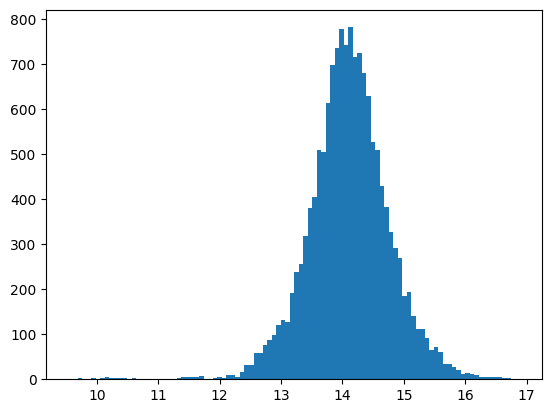

In [118]:
pre_features, pre_ids = get_predict_data(pre_path, encoder, train_colums)
p_price = net(pre_features).detach().numpy()

plt.hist(p_price, bins=100)
plt.show()

# 使用均值和标准差还原预测结果
pre_labels = np.expm1(net(pre_features).detach().numpy())

result_df = pd.DataFrame({
    'id': pre_ids.flatten(),
    'price': pre_labels.flatten()
})

result_df.to_csv(outputPath, index=False)